In [4]:
%pwd

'/webapps/piglegsurgery'

In [24]:
from typing import Union, Optional
from pathlib import Path
import json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from loguru import logger
import pandas as pd
import scipy.spatial

# from piglegsurgeryweb.uploader.views import show_collection_reports_list

HEATMAP_EXPERT_POINTS_PATH = sorted(list(Path("./").glob("**/*points_normalized.*.npy")))[-1]


assert HEATMAP_EXPERT_POINTS_PATH.exists()

MEDIA_ROOT = Path("../piglegsurgeryweb/media/")
MEDIA_ROOT = Path("./piglegsurgeryweb/media/")
assert MEDIA_ROOT.exists()



In [25]:

fn = sorted(list(Path(".").glob("**/*list_of_all_stitches*.xlsx")))[-1]
print(fn)
dfall = pd.read_excel(fn)

if "done_by_expert" not in dfall.columns:
    print("Adding done_by_expert column")
    dfall["done_by_expert"] = dfall["filename"].str.contains("Ekn").astype(float)
    dfall["done_by_expert"] = dfall["done_by_expert"].astype(bool)
# dfall.done_by_expert.value_counts()


devel/list_of_all_stitches_sorted_by_duration.2025-02-14_21-57-22.xlsx


In [47]:


def get_outputdir(patch:str):
    img_pths = list((MEDIA_ROOT / "upload/").glob(f"*/*{patch}*"))
    mediafile_path = sorted(img_pths)[0]
    mediafile_path = mediafile_path.absolute().resolve()

    outputdir = list(list((MEDIA_ROOT ).glob(f"*/*{patch}*.zip"))[-1].parent.glob("*/meta.json"))[-1].parent

    outputdir = outputdir.absolute().resolve()
    return outputdir, mediafile_path



In [48]:
fn = dfall[
    (dfall["done_by_expert"]==True)
    & (dfall["filename"].str.contains(".mp4"))
].filename.values[1]

patch = Path(fn).stem
patch
outputdir, mediafile_path = get_outputdir(patch)
outputdir
mediafile_path


PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-092634_Ekn_Ana_8_539656a54ac190c20b29639678b8c64bc255d01a/Ekn_Ana_8.mp4')

In [40]:
dfall

,Unnamed: 0,filename,annotation_annotation_annotation,annotation_annotation_time_and_movements,report_url,Needle holder stitch heatmap score [%],AI movement evaluation stitch [%],Stitch duration [s],Stitch start at [s],Needle holder stitch area presence [%],...,Forceps curved piercing visibility [%],Forceps curved piercing length [m],Needle holder piercing heatmap score [%],Needle holder piercing heatmap l2 distance [-],Forceps piercing heatmap score [%],Forceps piercing heatmap l2 distance [-],Scissors piercing heatmap score [%],Scissors piercing heatmap l2 distance [-],stitch_id,done_by_expert
0,0,Pretest_Einzelknopfnaht_Temeschinko.Ina.mp4,NaN,NaN,http://suran.kky.zcu.cz:8000//uploader/web_rep...,NaN,NaN,42.733333,13.866667,17.834395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
1,1,Bildschirmaufnahme_2024-10-07_um_13.31.25.mov,NaN,NaN,http://suran.kky.zcu.cz:8000//uploader/web_rep...,NaN,56.611203,199.066667,41.000000,63.800225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2,2,pigleg_test_4.mp4,00:00:02 stitch_start\r\n00:00:04 stitch_end,1.0,http://suran.kky.zcu.cz:8100//uploader/web_rep...,NaN,79.405902,2.000000,2.000000,43.478261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
3,3,EKN_10_CBA.mp4,NaN,NaN,http://suran.kky.zcu.cz:8000//uploader/web_rep...,NaN,88.039617,31.333333,4.466667,62.946429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True
4,4,EinzelknopfnahtGenoux-Jonas.mov,NaN,NaN,http://suran.kky.zcu.cz:8000//uploader/web_rep...,NaN,81.318603,37.533333,0.400000,87.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,356,IMG_1337.mov,Akkurate Stiche! Beim ersten Knoten verwendest...,5.0,http://suran.kky.zcu.cz//uploader/web_report/d...,NaN,76.646098,67.133333,290.066667,74.078341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,False
357,357,IMG_3597.mov,NaN,NaN,http://suran.kky.zcu.cz//uploader/web_report/6...,NaN,83.429174,51.266667,298.600000,77.859238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,False
358,358,Stresstest_nicht_gekürztes_Vid.webm,NaN,NaN,http://suran.kky.zcu.cz//uploader/web_report/c...,NaN,77.306725,59.800000,303.733333,73.282443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,False
359,359,STresstest.webm,NaN,NaN,http://suran.kky.zcu.cz//uploader/web_report/b...,NaN,66.601286,84.866667,105.800000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,False


In [28]:
def compare_distributions_by_l2_distance(pts, points, bw_adjust1=1.0, bw_adjust2=1.0):
    # Compute both KDEs.
    kde_ground = gaussian_kde(pts.T)
    kde_other = gaussian_kde(points.T)

    kde_ground.set_bandwidth(bw_method=kde_ground.factor * bw_adjust1)
    kde_other.set_bandwidth(bw_method=kde_other.factor * bw_adjust2)

    # Define a common grid that covers the support of both datasets.
    x_min = min(pts[:, 0].min(), points[:, 0].min())
    x_max = max(pts[:, 0].max(), points[:, 0].max())
    y_min = min(pts[:, 1].min(), points[:, 1].min())
    y_max = max(pts[:, 1].max(), points[:, 1].max())

    grid_size = 20
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    # Evaluate both KDEs on the grid.
    density_ground = kde_ground(grid_coords).reshape(X.shape)
    density_other  = kde_other(grid_coords).reshape(X.shape)

    # Calculate a similarity measure (for example, L2 distance).
    l2_distance = np.sqrt(np.sum((density_ground - density_other)**2))
    # print("L2 distance between KDEs:", l2_distance)
    return l2_distance




def mean_mahalanobis_to_distribution(pts, points):
    """
    Computes the average Mahalanobis distance from each point in `pts`
    to the mean of `points`, using the covariance of `points`.
    """
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)

    try:
        inv_cov = np.linalg.inv(cov)
        distances = [scipy.spatial.distance.mahalanobis(p, mean, inv_cov) for p in pts]
        return np.mean(distances)
    except np.linalg.LinAlgError:
        return np.inf



def logistic_normalize(d, midpoint=700, steepness=0.01):
    """
    Uses a logistic function to normalize the distance.

    Parameters:
      d (float or np.ndarray): The distance value(s).
      midpoint (float): The distance value corresponding to 0.5.
      steepness (float): Controls the slope of the logistic curve.

    Returns:
      float or np.ndarray: A normalized value between 0 and 1.
    """
    return 1 / (1 + np.exp(-steepness * (d - midpoint)))

def logistic_normalize_inverted(d, midpoint=700, steepness=0.01):
    """
    Normalizes a distance d so that:
      - d = 0 maps to 1.0 (best),
      - d = midpoint maps to 0.5,
      - d -> infinity maps to 0.0.

    Parameters:
      d (float or np.ndarray): The distance value(s).
      midpoint (float): The distance at which the result is 0.5.
      steepness (float): Controls the slope of the logistic curve.

    Returns:
      float or np.ndarray: A normalized value in the range [0, 1].
    """
    # Ensure d is a NumPy array for vectorized operations
    d = np.array(d, dtype=float)
    normalized = 1 / (1 + np.exp(steepness * (d - midpoint)))

    # If you want to force exactly 1.0 when d == 0, adjust those entries:
    # normalized[d == 0] = 1.0

    return normalized





def compare_heatmaps_plot(
        outputdir: Union[str,Path], points_px:Optional[np.array]=None, pix_size_m:Optional[float]=None, filename=None,
        image:Optional[np.array]=None,
        tool_id=0,
        cmap="Greens",
        levels=3
):

    outputdir = Path(outputdir)
    if pix_size_m is None:
        with open(outputdir / "meta.json", "r") as f:
            meta = json.load(f)
        pix_size_m = meta["qr_data"]["pix_size"]

    if points_px is None:
        with open(outputdir / "tracks_points.json", "r") as f:
            tracks_points = json.load(f)
        points_px = np.asarray(tracks_points["data_pixels"][tool_id])
    else:
        points_px = np.asarray(points_px)

    logger.debug(f"{points_px.shape=}")
    logger.debug(f"{pix_size_m=}")
    if points_px.size < 8:
        logger.warning("No points found for heatmap")
        return None, None
    if pix_size_m is None:
        logger.warning("No pix_size_m found for heatmap")
        return None, None
    # points_m = points_px * pix_size_m

    pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)

    plt.figure()

    if image is None:
        fn_small = list(outputdir.glob("__cropped.*.jpg"))[0]
        image = skimage.io.imread(fn_small, as_gray=True)
    else:
        if image.ndim == 3:
            image = skimage.color.rgb2gray(image)
    plt.imshow(image, cmap='gray')
    plt.plot(points_px[:, 0], points_px[:, 1], ".", alpha=0.2, color="red", markersize=1)
    # alpha=0.5, markerfacecolor=(1,1,0,0.1)
    # )
    # save dimensions of the plot

    points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m
    # distance = compare_distributions_by_l2_distance(points_normed, pts_gt, bw_adjust1=2.0, bw_adjust2=2.0)
    midpoint = 1000
    steepness=0.005
    dist = mean_mahalanobis_to_distribution(points_normed, pts_gt)
    midpoint = 1.2
    steepness=4.01

    sigma = np.mean(np.var(pts_gt))
    sigma = 4000.0
    # score = np.exp( - l2_distance / sigma)
    print(f"{dist=}")
    score = logistic_normalize_inverted(dist, midpoint=midpoint, steepness=steepness)
    # score  = distance
    score_100 = 100 * score

    if score_100 < 70:
        students_cmap = "Reds"
    elif score_100 < 85:
        students_cmap = "Oranges"
    else:
        students_cmap = "Greens"


    pts_px = (pts_gt / pix_size_m) + np.median(points_px, axis=0)
    sns.kdeplot(x=points_px[::10,0], y=points_px[::10,1],
                # cmap=None,
                cmap=students_cmap,
                fill=True, bw_adjust=2., levels=levels,alpha=0.5)

    sns.kdeplot(x=pts_px[::10,0], y=pts_px[::10,1], cmap="Greens", fill=False, bw_adjust=2.0, levels=levels)

    plt.text(0.02 * image.shape[1], 0.98 * image.shape[0], f"{score_100:.0f}%", fontsize=12, color="red")

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    # turn off axis
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
    return dist, score


In [115]:

def compare_heatmaps_plot_one_contour(
        outputdir: Union[str,Path], points_px:Optional[np.array]=None, pix_size_m:Optional[float]=None, filename=None,
        image:Optional[np.array]=None,
        tool_id=0,
        cmap="Greens",
        levels=3,
        percentil=0.8,
        red_threshold=0.7,
        bw_adjust1 = 2.0,
):
    """Create a heatmap comparing student points with expert points.

    Function is called during the report generation.

    :param percentil: float: Percentil for the contour line. Default is 0.8 (80%). Also used for score color.
    :param red_threshold: float: Threshold for red color. Default is 0.7 (70%). Used for score color.
    :param bw_adjust1: float: Bandwidth adjustment for the expert KDE. Default is 2.0.
    """

    outputdir = Path(outputdir)
    if pix_size_m is None:
        with open(outputdir / "meta.json", "r") as f:
            meta = json.load(f)
        pix_size_m = meta["qr_data"]["pix_size"]

    if points_px is None:
        with open(outputdir / "tracks_points.json", "r") as f:
            tracks_points = json.load(f)
        points_px = np.asarray(tracks_points["data_pixels"][tool_id])
    else:
        points_px = np.asarray(points_px)

    logger.debug(f"{points_px.shape=}")
    logger.debug(f"{pix_size_m=}")
    if points_px.size < 8:
        logger.warning("No points found for heatmap")
        return None, None
    if pix_size_m is None:
        logger.warning("No pix_size_m found for heatmap")
        return None, None
    # points_m = points_px * pix_size_m

    pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)

    plt.figure()

    if image is None:
        fn_small = list(outputdir.glob("__cropped.*.jpg"))[0]
        image = skimage.io.imread(fn_small, as_gray=True)
    else:
        if image.ndim == 3:
            image = skimage.color.rgb2gray(image)
    plt.imshow(image, cmap='gray')
    # alpha=0.5, markerfacecolor=(1,1,0,0.1)
    # )
    # save dimensions of the plot

    points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m


    # Výpočet KDE pro expertí data
    pts_px = (pts_gt / pix_size_m) + np.median(points_px, axis=0)
    points_expert = pts_px
    points_actual = points_px
    kde_expert = gaussian_kde(points_expert.T)


    kde_expert.set_bandwidth(bw_method=kde_expert.factor * bw_adjust1)
    # kde_other.set_bandwidth(bw_method=kde_other.factor * bw_adjust2)

    # Mřížka pro KDE
    x_min, y_min = points_expert.min(axis=0)
    x_max, y_max = points_expert.max(axis=0)
    X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde_expert(positions), X.shape)

    # Najdi threshold pro 50% konturu
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    cum_probs = np.cumsum(Z_sorted)
    cum_probs /= cum_probs[-1]
    threshold_50 = Z_sorted[np.searchsorted(cum_probs, percentil)]

    # Zjisti hustotu pro body points_actual
    densities_actual = kde_expert(points_actual.T)

    # Rozdělení podle toho, jestli jsou uvnitř nebo vně 50%
    inside_mask = densities_actual >= threshold_50
    outside_mask = ~inside_mask

    score = np.sum(inside_mask) / len(inside_mask)


    # plt.plot(points_px[:, 0], points_px[:, 1], ".", alpha=0.2, color="red", markersize=1)

    # KDE kontura
    cs = plt.contour(X, Y, Z, levels=[threshold_50], colors='orange', linewidths=2, label=f'Experts  {int(percentil * 100)}%')
    from matplotlib.lines import Line2D
    legend_proxy = [Line2D([0], [0], color='orange', lw=2, label=f'Experts {int(percentil * 100)}%')]
    plt.legend(handles=legend_proxy)

    # KDE heatmapa (volitelná, můžeš vypnout)
    # plt.imshow(Z.T, origin='lower', extent=[x_min, x_max, y_min, y_max], aspect='auto', cmap='Greens', alpha=0.5)

    # Body expertů (např. černé)
    # plt.scatter(points_expert[:, 0], points_expert[:, 1], s=10, color='black', label='Expert')

    # Body actual rozdělené dle hustoty
    plt.scatter(points_actual[inside_mask, 0], points_actual[inside_mask, 1], s=1, color='green',
                # label=f'Actual (inside {int(percentil * 100)}%)'
                label="_no_legend_"
                )
    plt.scatter(points_actual[outside_mask, 0], points_actual[outside_mask, 1], s=1, color='red',
                # label=f'Actual (outside {int(percentil * 100)}%)'
                label="_no_legend_"
                )
    dist = score

    score_100 = 100 * score
    green_threshold_100 = percentil * 100
    red_threshold_100 = red_threshold * 100
    if score_100 < red_threshold_100:
        students_cmap = "Reds"
        text_color = "red"
    elif score_100 < green_threshold_100:
        text_color = "orange"
        students_cmap = "Oranges"
    else:
        students_cmap = "Greens"
        text_color = "green"

    plt.text(0.02 * image.shape[1], 0.98 * image.shape[0], f"{score_100:.0f}%", fontsize=16, color=text_color,
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.3')

             )

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    plt.legend(handles=legend_proxy)
    # turn off axis
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
    return dist, score


2025-06-11 22:11:36.455 | DEBUG    | __main__:compare_heatmaps_plot_one_contour:24 - points_px.shape=(599, 2)
2025-06-11 22:11:36.456 | DEBUG    | __main__:compare_heatmaps_plot_one_contour:25 - pix_size_m=0.0004053349624217903
/tmp/ipykernel_386186/3578613572.py:89: UserWarning: The following kwargs were not used by contour: 'label'
  cs = plt.contour(X, Y, Z, levels=[threshold_50], colors='orange', linewidths=2, label=f'Experts  {int(percentil * 100)}%')


(0.9215358931552587, 0.9215358931552587)

<Figure size 720x720 with 0 Axes>

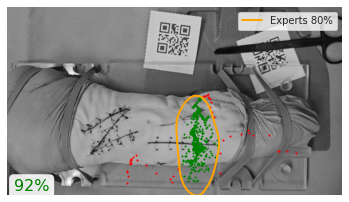

In [116]:

fn = np.random.choice(dfall[dfall["done_by_expert"]==True].filename.values)
patch = Path(fn).stem
patch
outputdir, mediafile_path = get_outputdir(patch)
plt.figure(figsize=(10,10))
# compare_heatmaps_plot(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", levels=3)
compare_heatmaps_plot_one_contour(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", percentil=0.80)


In [82]:
outputdir

PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20240820-091356_clqtamipyybu/SA_20240820-091356')

# Prepare expert normed data



(16236, 2)

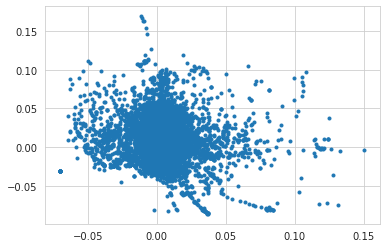

In [29]:
# the actual (old) stored values
pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)
plt.plot(pts_gt[:,0], pts_gt[:,1], ".")
pts_gt.shape


In [30]:
!pwd

/webapps/piglegsurgery


In [38]:
def get_data_from_one_outputdir(patch):
    outputdir, mediafile_path = get_outputdir(patch)
    with open(outputdir / "tracks_points.json", "r") as f:
        tracks_points = json.load(f)
    with open(outputdir / "meta.json", "r") as f:
        meta = json.load(f)
    return tracks_points, meta, outputdir, mediafile_path

(15849, 2)


<AxesSubplot:>

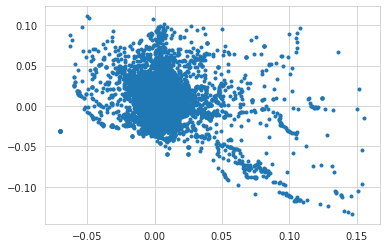

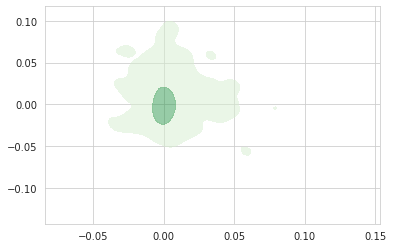

In [32]:

dfall_expert = dfall[dfall["done_by_expert"]==True]["filename"].values
# dfall_expert = dfall[dfall["done_by_expert"]==False]["filename"].values

points_expert = []
for fn in dfall_expert:
    try:
        patch = Path(fn).stem

        tracks_points, meta, outputdir, mediafile_path = get_data_from_one_outputdir(patch)

        if "qr_data" not in meta:
            print(f"Skipping {fn} because no qr_data found in meta.json")
            continue
        pix_size_m = meta["qr_data"]["pix_size"]

        points_px = np.asarray(tracks_points["data_pixels"][0])
        points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m
        points_expert.append(points_normed)
    except Exception as e:
        print(f"Error in {fn}: {e}")
points_expert = np.concatenate(points_expert)
print(points_expert.shape)


plt.plot(points_expert[:,0], points_expert[:,1], ".")
plt.figure()


sns.kdeplot(x=points_expert[::10,0], y=points_expert[::10,1], cmap="Greens", fill=True, bw_adjust=1., levels=3,alpha=0.5)



(-0.1334643928015782, 0.11109030639382633)

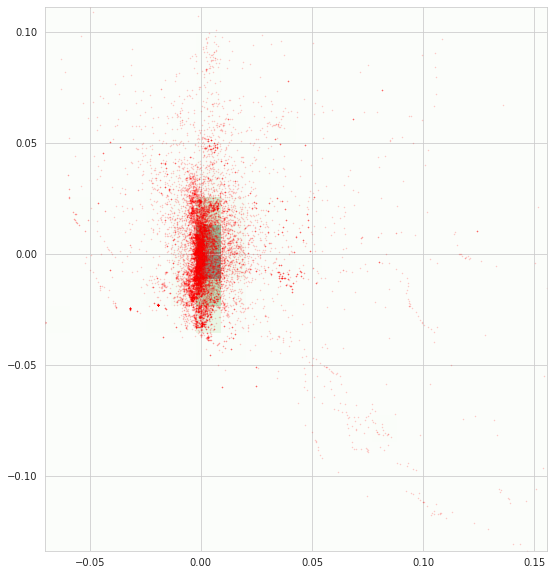

In [35]:
# make density model of points_expert
kde_expert = gaussian_kde(points_expert.T)
# plot the countour lines of the kde_expert
x_min = points_expert[:, 0].min()
x_max = points_expert[:, 0].max()
y_min = points_expert[:, 1].min()
y_max = points_expert[:, 1].max()
grid_size = 20
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([X.ravel(), Y.ravel()])
density_expert = kde_expert(grid_coords).reshape(X.shape)
plt.figure(figsize=(10,10))
plt.imshow(density_expert, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='Greens', alpha=0.5)
plt.plot(points_expert[:, 0], points_expert[:, 1], ".", alpha=0.2, color="red", markersize=1)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

0.9208782888510316


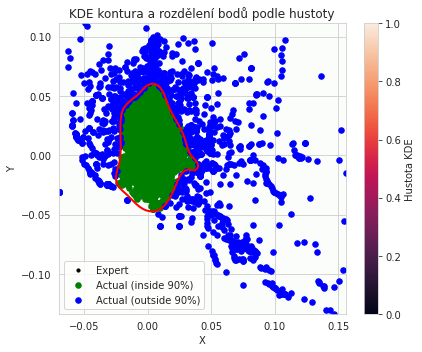

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
percentil = 0.9
bw_adjust1 = 2.0

points_actual = points_expert

# Výpočet KDE pro expertí data
kde_expert = gaussian_kde(points_expert.T)


kde_expert.set_bandwidth(bw_method=kde_expert.factor * bw_adjust1)
# kde_other.set_bandwidth(bw_method=kde_other.factor * bw_adjust2)

# Mřížka pro KDE
x_min, y_min = points_expert.min(axis=0)
x_max, y_max = points_expert.max(axis=0)
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde_expert(positions), X.shape)

# Najdi threshold pro 50% konturu
Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cum_probs = np.cumsum(Z_sorted)
cum_probs /= cum_probs[-1]
threshold_50 = Z_sorted[np.searchsorted(cum_probs, percentil)]

# Zjisti hustotu pro body points_actual
densities_actual = kde_expert(points_actual.T)

# Rozdělení podle toho, jestli jsou uvnitř nebo vně 50%
inside_mask = densities_actual >= threshold_50
outside_mask = ~inside_mask

score = np.sum(inside_mask) / len(inside_mask)

# Vykreslení
plt.figure(figsize=(6, 5))

# KDE kontura
plt.contour(X, Y, Z, levels=[threshold_50], colors='red', linewidths=2)

# KDE heatmapa (volitelná, můžeš vypnout)
plt.imshow(Z.T, origin='lower', extent=[x_min, x_max, y_min, y_max], aspect='auto', cmap='Greens', alpha=0.5)

# Body expertů (např. černé)
plt.scatter(points_expert[:, 0], points_expert[:, 1], s=10, color='black', label='Expert')

# Body actual rozdělené dle hustoty
plt.scatter(points_actual[inside_mask, 0], points_actual[inside_mask, 1], s=30, color='green', label=f'Actual (inside {int(percentil * 100)}%)')
plt.scatter(points_actual[outside_mask, 0], points_actual[outside_mask, 1], s=30, color='blue', label=f'Actual (outside {int(percentil * 100)}%)')

print(score)



plt.legend()
plt.title("KDE kontura a rozdělení bodů podle hustoty")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Hustota KDE")
plt.tight_layout()
plt.show()


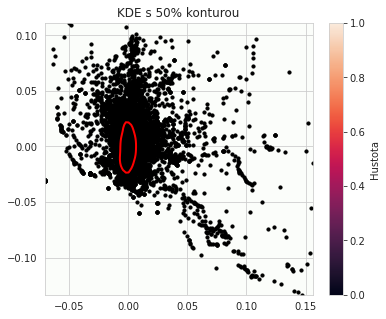

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
percentil= 0.5

# Výpočet KDE
kde_expert = gaussian_kde(points_expert.T)

# Vytvoření mřížky pro výpočet hustoty
x_min, y_min = points_expert.min(axis=0)
x_max, y_max = points_expert.max(axis=0)

X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde_expert(positions), X.shape)

# Seřazení hodnot hustoty a výpočet kumulativního součtu
Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cum_probs = np.cumsum(Z_sorted)
cum_probs /= cum_probs[-1]

# Najdi threshold odpovídající 50 % kumulativní hustoty
threshold_50 = Z_sorted[np.searchsorted(cum_probs, percentil)]

# Vykreslení
plt.figure(figsize=(6, 5))
plt.contour(X, Y, Z, levels=[threshold_50], colors='red', linewidths=2)
plt.imshow(Z.T, origin='lower', extent=[x_min, x_max, y_min, y_max], aspect='auto', cmap='Greens', alpha=0.5)
plt.scatter(points_expert[:, 0], points_expert[:, 1], s=10, color='black')
plt.title("KDE s 50% konturou")
plt.colorbar(label="Hustota")
plt.show()

2025-06-11 21:31:07.109 | DEBUG    | __main__:compare_heatmaps_plot_one_contour:23 - points_px.shape=(493, 2)
2025-06-11 21:31:07.110 | DEBUG    | __main__:compare_heatmaps_plot_one_contour:24 - pix_size_m=0.00048183408378360413


(0.0, 0.0)

<Figure size 720x720 with 0 Axes>

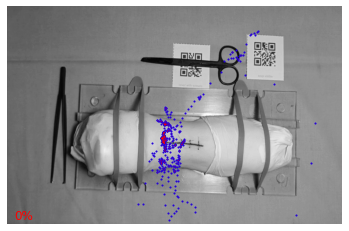

In [67]:

fn = np.random.choice(dfall[dfall["done_by_expert"]==True].filename.values)
patch = Path(fn).stem
patch
outputdir, mediafile_path = get_outputdir(patch)
plt.figure(figsize=(10,10))
# compare_heatmaps_plot(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", levels=3)
compare_heatmaps_plot_one_contour(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", percentil=0.9)


In [11]:
with open(outputdir / "meta.json", "r") as f:
    meta = json.load(f)
meta

{'duration_s_get_parameters_for_crop_rotate_rescale': 111.01326966285706,
 'orig fps': 30,
 'orig totalframecount': 1660,
 'orig frame_width': 1920,
 'orig frame_height': 1080,
 'ffmpeg_subprocess_params': 'ffmpeg -i /webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-091158_Ekn_Ana_4_bb34a360434b16e8e76dedcb224c3180e61e7175/Ekn_Ana_4.mp4 -filter:v fps=fps=15,scale=720:trunc(ow/a/2)*2 -an -y -b:v 1000k /webapps/piglegsurgery/piglegsurgeryweb/media/SA_20240820-091158_1pys6yarf1k9/SA_20240820-091158/__cropped.mp4',
 'duration_s_do_crop_rotate_rescale': 27.483112335205078,
 'filename_full': '/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-091158_Ekn_Ana_4_bb34a360434b16e8e76dedcb224c3180e61e7175/Ekn_Ana_4.mp4',
 'fps': 30,
 'frame_count': 1660,
 'frame_width': 0,
 'frame_height': 0,
 'qr_data': {'is_microsurgery': False,
  'pix_size_method': 'weighted_average',
  'is_detected': False,
  'box': [],
  'pix_size': 0.0004657364460534068,
  'incision_bboxes': [[320.2351

In [12]:
pta = np.random.normal(loc=[5,5], scale=2, size=[10,2])
pta


array([[ 8.2041175 ,  7.84076447],
       [ 3.36295343, -1.43669077],
       [ 3.56601784,  7.53104646],
       [ 4.32302182,  4.27600563],
       [ 7.42738764,  4.49087149],
       [ 2.42653328, 10.62873733],
       [ 3.28538443,  6.48266386],
       [ 0.92886706,  0.39832081],
       [ 4.26845168,  2.94263294],
       [ 4.14979587,  7.90226391]])

In [65]:
ptb = np.random.normal(loc=[5,5], scale=5, size=[10,2])
print(mean_mahalanobis_to_distribution(ptb, pta))
ptb


4.183732440774877


array([[-3.42896324,  9.24531159],
       [16.13818288,  6.1003344 ],
       [ 8.61960477,  8.06788087],
       [11.49140649,  6.77459095],
       [ 8.84803563,  9.73984745],
       [-0.09464469, 12.69280832],
       [ 3.14309094, -1.01620272],
       [ 1.28242592, -0.1293244 ],
       [ 9.91970993,  4.04397248],
       [ 0.5575317 ,  7.42005109]])